In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [12]:
df_train = pd.read_csv("Train_Arabic_Digit.csv", header = None)
df_train["block"] = df_train.isnull().all(axis=1).cumsum()

df_test = pd.read_csv("Test_Arabic_Digit.csv", header = None)
df_test["block"] = df_test.isnull().all(axis=1).cumsum()

df2_train = {i: df_train.loc[df_train.block == i, df_train.columns.drop('block')].dropna()
       for i in range(0, df_train.block.iat[-1])}

# Create df3, a dictionary of concatenated blocks by digit
df_train["block"] = np.floor(df_train["block"] / 660)
df3_train = {i: df_train.loc[df_train.block == i, df_train.columns.drop('block')].dropna()
       for i in range(10)}

# [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'block']
# df_test['block'] = np.floor(df_test['block'] / 220)
df_cut_test = df_test.dropna()
df_cut_test = {i: df_cut_test.loc[df_cut_test.block == i, df_cut_test.columns.drop('block')]
       for i in range(0, df_cut_test.block.iat[-1])}

In [13]:
df_test_time = df_cut_test
for num in range(2199):
    df_test_time[num][13] = ""
    # print(num)
    for i in range(df_test_time[num].shape[0]):
        # print("hi")
        df_test_time[num].iloc[i, 13] = 3 * float(i) / df_test_time[num].shape[0]


In [14]:
for digit in range(6599):
    df2_train[digit][13] = ""
    for i in range(df2_train[digit].shape[0]):
        df2_train[digit].iloc[i, 13] = 3 * float(i) / df2_train[digit].shape[0]

In [15]:
df2_blocked = {}
for digit in range(10):
    print("hi")
    df2_blocked[digit] = pd.DataFrame(columns=df2_train[digit].columns)
    if digit == 9:
        for i in range(659):
            df2_blocked[digit] = pd.concat([df2_blocked[digit], df2_train[i + digit * 660]])
    else:
        for i in range(660):
            df2_blocked[digit] = pd.concat([df2_blocked[digit], df2_train[i + digit * 660]])

hi
hi
hi
hi
hi
hi
hi
hi
hi
hi


In [ ]:
df2_genderblocked = {}
for digit in range(10):
    print("hi")
    df2_genderblocked[digit] = pd.DataFrame(columns=df2_train[digit].columns)
    if digit == 9:
        for i in range(330):
            df2_genderblocked[2 * digit] = pd.concat([df2_genderblocked[2 * digit], df2_train[i + digit * 660]])
        for i in range(330, 659):
            df2_genderblocked[2 * digit + 1] = pd.concat([df2_genderblocked[2 * digit + 1], df2_train[i + digit * 660]])
    else:
        for i in range(330):
            df2_genderblocked[2 * digit] = pd.concat([df2_genderblocked[2 * digit], df2_train[i + digit * 660]])
        for i in range(330, 660):
            df2_genderblocked[2 * digit + 1] = pd.concat([df2_genderblocked[2 * digit + 1], df2_train[i + digit * 660]])

In [44]:
time_gmms = []

for i in range(10):
    gmm = GaussianMixture(n_components=8, covariance_type='diag').fit(df2_blocked[i])
    time_gmms.append(gmm)

In [ ]:
male_gmms = []
female_gmms = []
for i in range(10):
    gmm_male = GaussianMixture(n_components=8, covariance_type='diag').fit(df2_genderblocked[2 * i])
    gmm_female = GaussianMixture(n_components=8, covariance_type='diag').fit(df2_genderblocked[2 * i + 1])
    male_gmms.append(gmm_male)
    female_gmms.append(gmm_female)

In [45]:
predictions_time = []
for i in range(2199):
    max_score = -10000
    max_GMM = -1
    for gmm_num in range(len(time_gmms)):
        score = time_gmms[gmm_num].score(df_test_time[i])
        if score > max_score:
            max_GMM = gmm_num
            max_score = score
    predictions_time.append(max_GMM)


In [47]:
correct = 0
wrongs = np.zeros(len(predictions_time))
wrongs = wrongs - 1
for i in range(len(predictions_time)):
    if predictions_time[i] == np.floor(i / 220):
        correct += 1
        wrongs[i] = predictions_time[i]

correct / 2199

0.9613460663938154

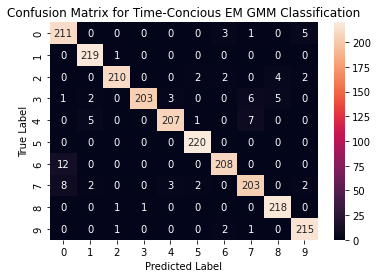

In [49]:
labels = []
for i in range(2199):
    labels.append(int(i/220))

cm = pd.DataFrame(confusion_matrix(labels, predictions_time))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix for Time-Concious EM GMM Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.savefig("em_confusion_matrix.png", dpi=300)